In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
#Link for dataset
#https://www.kaggle.com/kazanova/sentiment140
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1")
df.columns = ["label", "time", "date", "query", "username", "text"]
df.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [20]:
df.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [21]:
df.iloc[0]['text']

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [23]:
df.drop(['time','date','query','username'], axis=1,inplace=True)

In [24]:
df.head()

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


# Text Preprocessing

In [25]:
set(df['label'])

{0, 4}

In [26]:
df['label'][df['label']==4]=1
dfPos = df[df['label']==1]
dfNeg = df[df['label']==0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
dfPos.head()

,label,text
799999,1,I LOVE @Health4UandPets u guys r the best!!
800000,1,im meeting up with one of my besties tonight! ...
800001,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,1,Being sick can be really cheap when it hurts t...
800003,1,@LovesBrooklyn2 he has that effect on everyone


In [28]:
dfPos.shape

(800000, 2)

In [29]:
dfPos = dfPos.iloc[:int(20000)]
dfNeg = dfNeg.iloc[:int(20000)]
df = pd.concat([dfPos,dfNeg])

In [30]:
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def textPreProcessor(text):
    cleaned = re.compile(r'<.*?>')
    text = re.sub(cleaned," ",text)
    rem = ' '
    for i in text:
        if i.isalnum():
            rem+=i
        else:
            rem+=" "
    text= rem.lower()

    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text)
    text = [w for w in words if w not in stopWords]

    ss = SnowballStemmer('english')
    text = " ".join([ss.stem(w) for w in text])
    return text

In [31]:
df['text'] = df['text'].apply(textPreProcessor)

In [32]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)

In [33]:
df.tail()

,label,text
19995,0,"[one, day, holiday]"
19996,0,"[feel, right, hate, damn, humprey]"
19997,0,"[geez, hv, read, whole, book, person, type, em..."
19998,0,"[threw, sign, donni, bent, get, thinge, made, ..."
19999,0,"[heather2711, good, thing, find, none, one, li..."


# Model Creation

In [34]:
X = df.text
y = df.label

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

maxLen = 1000
tkn = Tokenizer(num_words = 2000)
tkn.fit_on_texts(X)
seq = tkn.texts_to_sequences(X)
seqMat = sequence.pad_sequences(seq, maxlen = maxLen)

In [36]:
seqMat.shape

(40000, 1000)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(seqMat, y, test_size=0.3, random_state=101)

In [38]:
def tensorflow_based_model(): 
    inputs = Input(name='inputs',shape=[maxLen])
    layer = Embedding(2000,50,input_length=maxLen)(inputs)
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model 

In [39]:
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [40]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)

Epoch 1/6
315/315 [==============================] - 21s 54ms/step - loss: 0.6205 - accuracy: 0.6407 - val_loss: 0.5476 - val_accuracy: 0.7282
Epoch 2/6
315/315 [==============================] - 17s 53ms/step - loss: 0.5287 - accuracy: 0.7509 - val_loss: 0.8199 - val_accuracy: 0.6350
Epoch 3/6
315/315 [==============================] - 17s 53ms/step - loss: 0.5614 - accuracy: 0.7051 - val_loss: 0.5348 - val_accuracy: 0.7300
Epoch 4/6
315/315 [==============================] - 17s 53ms/step - loss: 0.4840 - accuracy: 0.7667 - val_loss: 0.5428 - val_accuracy: 0.7246
Epoch 5/6
315/315 [==============================] - 16s 52ms/step - loss: 0.4702 - accuracy: 0.7783 - val_loss: 0.5548 - val_accuracy: 0.7196
Epoch 6/6
315/315 [==============================] - 17s 53ms/step - loss: 0.4570 - accuracy: 0.7841 - val_loss: 0.5491 - val_accuracy: 0.7264


In [44]:
predictions = model.predict(X_test)

In [50]:
predictions = (predictions > 0.5) 

confusion matrix
[[4416 1530]
 [1639 4415]]


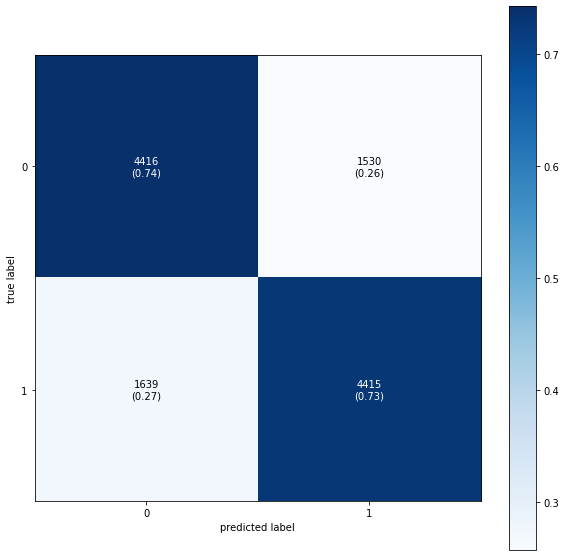

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
print("confusion matrix")
CR=confusion_matrix(Y_test, predictions)
print(CR)
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

dtype('float32')